# RTM Example with dynamic scheduling
We will perform RTM using the following steps:
1. Read the 10m resampled models output from the FWI notebook
2. Visualize the model
3. Build a small local compute cluster (2 workers)
4. Create list of shot locations 
5. Define the `timemute!`, `migrateshot`, and `stack` functions
6. Run the migration and write individual shot images to disk
7. Stack the individual shot images 
8. Perform a little post migration processing
9. Visualize Results

#### Note on runtime
This notebook takes approximately 20 minutes to run for 100 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Add required packages

In [1]:
using Distributed, PyPlot, Jets, JetPack, JetPackDSP, Printf

## Record time for start of notebook

In [2]:
time_beg = time()

1.604378015102503e9

## 1. Read the 10m resampled models output from the FWI notebook

In [3]:
file1 = "../50_fwi/marmousi_resampled_10m_349x1701_vtrue.bin"

nz,nx = 349,1701
dz,dx = 10.0,10.0

v1_orig = read!(file1, Array{Float32}(undef,nz,nx));

####  Apply a 7x7 rectangular mix smoother
We perform the RTM migration in a slightly smoothed model.

In [4]:
ns = 21
P = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=true)
M = JopMix(range(P), (7,7))
R = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=false)

s1 = R' ∘ M ∘ P * (1 ./ v1_orig)

v1 = 1 ./(s1);

#### Compute "reflectivity" by vertical numerical derivative

In [5]:
D = JopDifference(JetSpace(Float32,nz,nx), 1)
r1 = D * v1;

## 2. Visualize the velocity and reflectivity

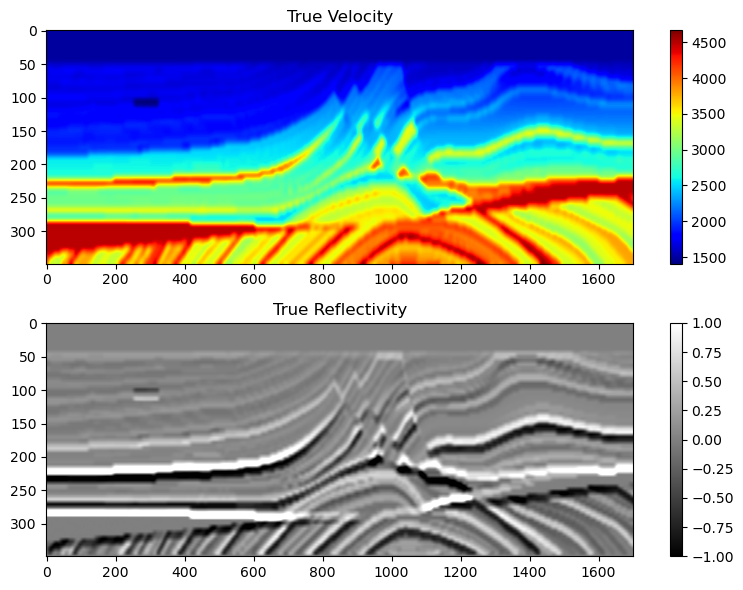

(vmin, vmax, rmax) = (1405.7601f0, 4667.2783f0, 199.77002f0)


In [6]:
vmin,vmax = extrema(v1)
rmax = maximum(abs,r1)
@show vmin,vmax,rmax;
figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity");

subplot(2,1,2); imshow(2 .* r1 ./ rmax,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("True Reflectivity");

tight_layout()

## 3. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [7]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [8]:
@everywhere using DistributedArrays, DistributedJets, DistributedOperations, Jets, JetPack, WaveFD, JetPackWaveFD, Random, LinearAlgebra, Schedulers

      From worker 3:	
      From worker 3:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 3:	  _OPENMP = '201511'
      From worker 3:	  OMP_DYNAMIC = 'FALSE'
      From worker 3:	  OMP_NESTED = 'FALSE'
      From worker 3:	  OMP_NUM_THREADS = '22'
      From worker 3:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 3:	  OMP_PROC_BIND = 'CLOSE'
      From worker 3:	  OMP_PLACES = '{22},{23},{24},{25},{26},{27},{28},{29},{30},{31},{32},{33},{34},{35},{36},{37},{38},{39},{40},{41},{42},{43}'
      From worker 3:	  OMP_STACKSIZE = '0'
      From worker 3:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 3:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 3:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 3:	  OMP_CANCELLATION = 'FALSE'
      From worker 3:	  OMP_DEFAULT_DEVICE = '0'
      From worker 3:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 3:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 3:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From wor

## 4. Create list of shot locations 
We use 100 shot locations, many times than our FWI example, and run at significantly higher frequency. 

In [9]:
nshots = 100
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)))
@show nshots;
@show sx;

nshots = 100
sx = [0, 172, 343, 515, 687, 859, 1030, 1202, 1374, 1545, 1717, 1889, 2061, 2232, 2404, 2576, 2747, 2919, 3091, 3263, 3434, 3606, 3778, 3949, 4121, 4293, 4465, 4636, 4808, 4980, 5152, 5323, 5495, 5667, 5838, 6010, 6182, 6354, 6525, 6697, 6869, 7040, 7212, 7384, 7556, 7727, 7899, 8071, 8242, 8414, 8586, 8758, 8929, 9101, 9273, 9444, 9616, 9788, 9960, 10131, 10303, 10475, 10646, 10818, 10990, 11162, 11333, 11505, 11677, 11848, 12020, 12192, 12364, 12535, 12707, 12879, 13051, 13222, 13394, 13566, 13737, 13909, 14081, 14253, 14424, 14596, 14768, 14939, 15111, 15283, 15455, 15626, 15798, 15970, 16141, 16313, 16485, 16657, 16828, 17000]


## 5. Define the `timemute!`, `migrateshot`, and `stack` functions
* `timemute!` mutes data to remove the direct arrival and refraction
* `migrateshot` runs the migrations for each shot and writes image and illumination files to scratch disk
* `stack` reads in shots from disk and stacks them

**TODO:** convert the IO to use CloudSeis as proxy for cloud storage

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [10]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

#### Global variables for number of samples and sample rate

In [11]:
@everywhere begin
    ntrec = 3001
    dtrec = 0.002
    dtmod = 0.001
end

#### Build the `timemute!` function 

In [12]:
@everywhere function timemute!(F, d, watervel, tmute)
    for i = 1:length(state(F, :rx)) 
        rx = state(F, :rx)
        rz = state(F, :rz)
        sx = state(F, :sx)
        sz = state(F, :sz)
        dist = sqrt((sx[1] - rx[i])^2 + (sz[1] - rz[i])^2)
        time = dist / watervel
        tbeg = 1
        tend = round(Int, (time + tmute) / state(F,:dtrec))
        tend = clamp(tend,1,size(d,1))
        d[tbeg:tend,i] .= 0
    end
    nothing
end

#### Build the `migrateshot` function

In [13]:
# notice we model to significantly shorter time than for FWI
@everywhere function migrateshot(isrc,nz,nx,dz,dx,_vtrue,_v,sx)
    @info "migrating shot $(isrc) on $(gethostname()) with id $(myid())..."
    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=10.0),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$isrc-$(randstring()).bin"),
        reportinterval=0)

    d = F*localpart(_vtrue) #here we model the data usually you would just read the data
    timemute!(F,d,1500,2/16) #mute out the direct and diving waves
    J = jacobian!(F, localpart(_v))
    illum = srcillum(J)
    m = J'*d
    close(F) #delete scratch files that we don't need anymore
    write(joinpath(scratch,"image_$(isrc).bin"),m)
    write(joinpath(scratch,"illum_$(isrc).bin"),illum)
end

#### Build the `stack` function

In [14]:
function stack(shots,nz,nx)
   img = zeros(Float32,nz,nx)
   ill = zeros(Float32,nz,nx)
   for isrc in shots
      img += read!(joinpath(scratch,"image_$(isrc).bin"), Array{Float32}(undef,nz,nx));
      ill += read!(joinpath(scratch,"illum_$(isrc).bin"), Array{Float32}(undef,nz,nx));
      rm(joinpath(scratch,"image_$(isrc).bin"))
      rm(joinpath(scratch,"illum_$(isrc).bin"))
   end
   return img,ill
end

stack (generic function with 1 method)

## 6. Run the migration and write individual shot images to disk

We use epmap to schedule the work for the migration.

In [15]:
#broadcast the models to the workers
_v1 = bcast(v1);

In [16]:
t1 = @elapsed begin
    epmap(i->migrateshot(i, nz, nx, dz, dx, _v1, _v1, sx), 1:nshots)
end
@show t1;

┌ Info: running task 1 on process 2; 2 workers total; 99 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
┌ Info: running task 2 on process 3; 2 workers total; 98 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 2 on cbox-HC44rs2 with id 3...
[ Info: migrating shot 1 on cbox-HC44rs2 with id 2...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 3 on process 2; 2 workers total; 97 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 3 on cbox-HC44rs2 with id 2...
┌ Info: running task 4 on process 3; 2 workers total; 96 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 4 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 5 on process 2; 2 workers total; 95 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 5 on cbox-HC44rs2 with id 2...
┌ Info: running task 6 on process 3; 2 workers total; 94 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 6 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 7 on process 2; 2 workers total; 93 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 7 on cbox-HC44rs2 with id 2...
┌ Info: running task 8 on process 3; 2 workers total; 92 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 8 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 9 on process 2; 2 workers total; 91 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 9 on cbox-HC44rs2 with id 2...
┌ Info: running task 10 on process 3; 2 workers total; 90 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 10 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 11 on process 2; 2 workers total; 89 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 11 on cbox-HC44rs2 with id 2...
┌ Info: running task 12 on process 3; 2 workers total; 88 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 12 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 13 on process 2; 2 workers total; 87 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 13 on cbox-HC44rs2 with id 2...
┌ Info: running task 14 on process 3; 2 workers total; 86 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 14 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 15 on process 2; 2 workers total; 85 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 15 on cbox-HC44rs2 with id 2...
┌ Info: running task 16 on process 3; 2 workers total; 84 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 16 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 17 on process 2; 2 workers total; 83 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 17 on cbox-HC44rs2 with id 2...
┌ Info: running task 18 on process 3; 2 workers total; 82 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 18 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 19 on process 2; 2 workers total; 81 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 19 on cbox-HC44rs2 with id 2...
┌ Info: running task 20 on process 3; 2 workers total; 80 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 20 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 21 on process 2; 2 workers total; 79 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 21 on cbox-HC44rs2 with id 2...
┌ Info: running task 22 on process 3; 2 workers total; 78 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 22 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 23 on process 2; 2 workers total; 77 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 23 on cbox-HC44rs2 with id 2...
┌ Info: running task 24 on process 3; 2 workers total; 76 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 24 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 25 on process 2; 2 workers total; 75 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 25 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 26 on process 3; 2 workers total; 74 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 26 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 27 on process 2; 2 workers total; 73 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 27 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 28 on process 3; 2 workers total; 72 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 28 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 29 on process 2; 2 workers total; 71 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 29 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 30 on process 3; 2 workers total; 70 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 30 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 31 on process 2; 2 workers total; 69 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 31 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 32 on process 3; 2 workers total; 68 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 32 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 33 on process 2; 2 workers total; 67 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 33 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 34 on process 3; 2 workers total; 66 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 34 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 35 on process 2; 2 workers total; 65 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 35 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 36 on process 3; 2 workers total; 64 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 36 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 37 on process 2; 2 workers total; 63 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 37 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 38 on process 3; 2 workers total; 62 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 38 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 39 on process 2; 2 workers total; 61 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 39 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 40 on process 3; 2 workers total; 60 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 40 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 41 on process 2; 2 workers total; 59 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 41 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 42 on process 3; 2 workers total; 58 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 42 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 43 on process 2; 2 workers total; 57 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 43 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 44 on process 3; 2 workers total; 56 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 44 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 45 on process 2; 2 workers total; 55 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 45 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 46 on process 3; 2 workers total; 54 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 46 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 47 on process 2; 2 workers total; 53 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 47 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 48 on process 3; 2 workers total; 52 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 48 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 49 on process 2; 2 workers total; 51 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 49 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 50 on process 3; 2 workers total; 50 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 50 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 51 on process 2; 2 workers total; 49 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 51 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 52 on process 3; 2 workers total; 48 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 52 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 53 on process 2; 2 workers total; 47 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 53 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 54 on process 3; 2 workers total; 46 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 54 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 55 on process 2; 2 workers total; 45 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 55 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 56 on process 3; 2 workers total; 44 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 56 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 57 on process 2; 2 workers total; 43 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 57 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 58 on process 3; 2 workers total; 42 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 58 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 59 on process 2; 2 workers total; 41 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 59 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 60 on process 3; 2 workers total; 40 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 60 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 61 on process 2; 2 workers total; 39 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 61 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 62 on process 3; 2 workers total; 38 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 62 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 63 on process 2; 2 workers total; 37 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 63 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 64 on process 3; 2 workers total; 36 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 64 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 65 on process 2; 2 workers total; 35 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 65 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 66 on process 3; 2 workers total; 34 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 66 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 67 on process 2; 2 workers total; 33 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 67 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 68 on process 3; 2 workers total; 32 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 68 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 69 on process 2; 2 workers total; 31 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 69 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 70 on process 3; 2 workers total; 30 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 70 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 71 on process 2; 2 workers total; 29 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 71 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 72 on process 3; 2 workers total; 28 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 72 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 73 on process 2; 2 workers total; 27 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 73 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 74 on process 3; 2 workers total; 26 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 74 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 75 on process 2; 2 workers total; 25 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 75 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 76 on process 3; 2 workers total; 24 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 76 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 77 on process 2; 2 workers total; 23 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 77 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 78 on process 3; 2 workers total; 22 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 78 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 79 on process 2; 2 workers total; 21 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 79 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 80 on process 3; 2 workers total; 20 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 80 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 81 on process 2; 2 workers total; 19 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 81 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 82 on process 3; 2 workers total; 18 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 82 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 83 on process 2; 2 workers total; 17 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 83 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 84 on process 3; 2 workers total; 16 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 84 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 85 on process 2; 2 workers total; 15 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 85 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 86 on process 3; 2 workers total; 14 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 86 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 87 on process 2; 2 workers total; 13 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 87 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 88 on process 3; 2 workers total; 12 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 88 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 89 on process 2; 2 workers total; 11 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 89 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 90 on process 3; 2 workers total; 10 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 90 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 91 on process 2; 2 workers total; 9 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 91 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 92 on process 3; 2 workers total; 8 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 92 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 93 on process 2; 2 workers total; 7 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 93 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 94 on process 3; 2 workers total; 6 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 94 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 95 on process 2; 2 workers total; 5 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 95 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 96 on process 3; 2 workers total; 4 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 96 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 97 on process 2; 2 workers total; 3 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 97 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 98 on process 3; 2 workers total; 2 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 98 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 99 on process 2; 2 workers total; 1 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 99 on cbox-HC44rs2 with id 2...


      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()


┌ Info: running task 100 on process 3; 2 workers total; 0 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 100 on cbox-HC44rs2 with id 3...


      From worker 2:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
      From worker 3:	kwargs[:imgcondition] = WaveFD.ImagingConditionStandard()
t1 = 947.582143233


In [17]:
@printf("Time for migrating %.2f minutes\n", t1 / 60)

Time for migrating 15.79 minutes


## 7. Stack the individual shot images 

In [18]:
shots = collect(1:nshots)
m1, illum1 = stack(shots,nz,nx);

## 8. Perform a little post migration processing

#### Laplacian filter to remove backscattered noise

In [19]:
L = JopLaplacian(JetSpace(Float32,nz,nx))

"Jet linear operator, (349, 1701) → (349, 1701)"

#### Apply low cut filter, illumination compensation, and gain

In [20]:
g = ([0:(nz-1);]*dz).^2 * ones(1,nx);

img1 = g .* (L * m1) ./ (illum1 .+ 1e-8 * maximum(abs, illum1));

@show extrema(img1)

extrema(img1) = (-2.372642018426671, 2.1026268839582434)


(-2.372642018426671, 2.1026268839582434)

#### Apply water bottom mute

In [21]:
img1[v1_orig.==1500.0] .= 0;

## 9. Visualize Results

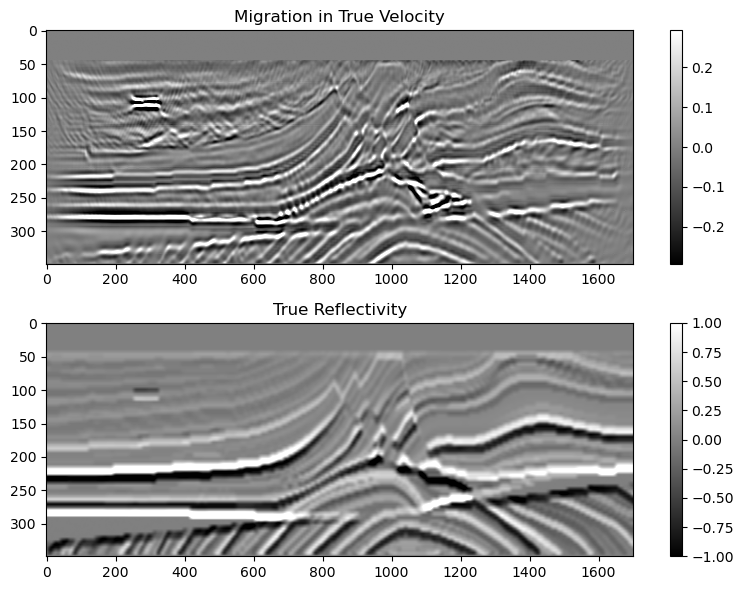

In [22]:
mrms1 = 2.5 * sqrt(norm(img1)^2 / length(img1))

figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(img1,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-mrms1,+mrms1);
title("Migration in True Velocity")

subplot(2,1,2); imshow(2 .* r1 ./ rmax,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("True Reflectivity");

tight_layout()

## Remove workers

In [23]:
rmprocs(workers())

Task (done) @0x00007fd930148760

In [24]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 16.33 minutes\n"